# Approaching news narrative classification with Support Vector Machines (SVM)

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import logging
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings

# Add parent directory to the system path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

# Import general proprocessing functions
from modules.data_loader import load_initial_data
from modules.text_segmentation import tokenize_text, handle_unusual_sentences
from modules.text_normalization import normalize_text
from modules.utils import setup_logging

from modules.modules_svm.preprocessing_svm import create_label_mapping
from modules.modules_svm.preprocessing_svm import prepare_data

# Import SVM specific analysis utility functions
from modules.modules_svm.analysis_util_svm import extract_confusion_data
from modules.modules_svm.analysis_util_svm import find_classes_with_tp_and_fn_language_check
from modules.modules_svm.analysis_util_svm import create_metrics_dataframe
from modules.modules_svm.analysis_util_svm import show_class_occurrences
from modules.modules_svm.analysis_util_svm import show_confusion_matrix
from modules.modules_svm.analysis_util_svm import sort_narratives_recall
from modules.modules_svm.analysis_util_svm import plot_difference_barchart
from modules.modules_svm.analysis_util_svm import plot_differences_heatmap

# Import SVM training function
from non_dl_methods.svm import train_svm

c:\Users\Niklas\Documents\Master\Semester1\3 NLP and Information Extraction\nlp_Backpropagandists_2024\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load and Preprocess Data

In [2]:
# Setup logging
setup_logging()
logger = logging.getLogger(__name__)

# Define paths
if '__file__' in globals():
    base_path = os.path.dirname(os.path.abspath(__file__))
else:
    base_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
documents_path = os.path.join(base_path, "training_data_16_October_release\\EN\\raw-documents")
annotations_file = os.path.join(base_path, "training_data_16_October_release\\EN\\subtask-2-annotations.txt")
output_dir = os.path.join(base_path, "code/CoNLL")
model_path = os.path.join(base_path, "code/models/svm_model.joblib")


# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

use_cached_data = True

if use_cached_data:
    input_file_full = os.path.join(base_path, "code\\df_normalized.csv")
    df = pd.read_csv(input_file_full)
    input_file_ua = os.path.join(base_path, "code\\df_normalized_ua.csv")
    df_ua = pd.read_csv(input_file_ua)
    input_file_cc = os.path.join(base_path, "code\\df_normalized_cc.csv")
    df_cc = pd.read_csv(input_file_cc)

else:
    # 1. Load and prepare initial data
    logger.info("Loading initial data...")
    df = load_initial_data(documents_path, annotations_file)
    logger.info(f"Loaded {len(df)} documents")

    # 2. Tokenize text
    logger.info("Tokenizing text...")
    df = tokenize_text(df)

    # 3. Handle unusual sentences
    logger.info("Handling unusual sentences...")
    df = handle_unusual_sentences(df)

    # 4. Normalize text
    logger.info("Normalizing text...")
    df, df_ua, df_cc = normalize_text(df)
    #print(df.head())
    #print(df.columns)
    #print(type(df['tokens_normalized'].iloc[0]))
    #print(df['tokens_normalized'].iloc[0])
    #print(df['narrative_subnarrative_pairs'].iloc[0])
    
    # 5. Convert to CoNLL-U format
    # only use when ConLL-U format is needed
    #logger.info("Converting to CoNLL-U format...")
    #convert_to_connlu(df, output_dir, 'tokens')
    logger.info("Preprocessing completed successfully")
    
# Filter dataframes to only include certain languages
#df = df[df['language'] == 'EN']
#df_ua = df_ua[df_ua['language'] == 'EN']
#df_cc = df_cc[df_cc['language'] == 'EN']

In [3]:
print(df_ua.shape, df_cc.shape, df.shape)

(1175, 8) (519, 8) (1694, 8)


## Training

We vectorize the data using different input representations:
- TF-IDF
- Bag-of-Words
- Multilingual Embeddings

and different dataset subsplits:
- split by topic Ukraine war/Climate change and train separate models
- use the entire dataset

and train a model to compare all combinations.

In [4]:
results = {}

### TF-IDF

In [5]:
logger.info("Starting SVM training with TF-IDF on Ukraine War data...")
training_results_tfidf_ua, counts_df_tfidf_ua, conf_matr_tfidf_ua, df_w_preds_tfidf_ua = train_svm(df_ua, base_path)
results['tfidf_ua'] = training_results_tfidf_ua
logger.info(f"SVM training completed.")


2025-01-25 10:40:00,241 - __main__ - INFO - Starting SVM training with TF-IDF on Ukraine War data...
2025-01-25 10:40:00,279 - modules.modules_svm.preprocessing_svm - INFO - Created mapping for 50 unique narratives
2025-01-25 10:40:00,899 - __main__ - INFO - SVM training completed.


In [6]:
logger.info("Starting SVM training with TF-IDF on Climate Change data...")
training_results_tfidf_cc, counts_df_tfidf_cc, conf_matr_tfidf_cc, df_w_preds_tfidf_cc = train_svm(df_cc, base_path)
results['tfidf_cc'] = training_results_tfidf_cc
logger.info(f"SVM training completed.")

2025-01-25 10:40:00,914 - __main__ - INFO - Starting SVM training with TF-IDF on Climate Change data...
2025-01-25 10:40:00,930 - modules.modules_svm.preprocessing_svm - INFO - Created mapping for 46 unique narratives
2025-01-25 10:40:01,250 - __main__ - INFO - SVM training completed.


c:\Users\Niklas\Documents\Master\Semester1\3 NLP and Information Extraction\nlp_Backpropagandists_2024\.venv\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 6 is present in all training examples.
  warnings.warn(


In [7]:
logger.info("Starting SVM training with TF-IDF on the complete data...")
training_results_tfidf_compl, counts_df_tfidf_compl, conf_matr_tfidf_compl, df_w_preds_tfidf_compl = train_svm(df, base_path)
results['tfidf_compl'] = training_results_tfidf_compl
logger.info(f"SVM training completed.")

2025-01-25 10:40:01,253 - __main__ - INFO - Starting SVM training with TF-IDF on the complete data...
2025-01-25 10:40:01,301 - modules.modules_svm.preprocessing_svm - INFO - Created mapping for 94 unique narratives
2025-01-25 10:40:02,330 - __main__ - INFO - SVM training completed.


### Bag-Of-Words

In [8]:
logger.info("Starting SVM training with Bag-Of-Words on Ukraine War data...")
training_results_bow_ua, counts_df_bow_ua, conf_matr_bow_ua, df_w_preds_bow_ua = train_svm(df_ua, base_path, vectorizer="bag-of-words")
results['bow_ua'] = training_results_bow_ua
logger.info(f"SVM training completed.")

2025-01-25 10:40:02,337 - __main__ - INFO - Starting SVM training with Bag-Of-Words on Ukraine War data...
2025-01-25 10:40:02,380 - modules.modules_svm.preprocessing_svm - INFO - Created mapping for 50 unique narratives


c:\Users\Niklas\Documents\Master\Semester1\3 NLP and Information Extraction\nlp_Backpropagandists_2024\.venv\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Niklas\Documents\Master\Semester1\3 NLP and Information Extraction\nlp_Backpropagandists_2024\.venv\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Niklas\Documents\Master\Semester1\3 NLP and Information Extraction\nlp_Backpropagandists_2024\.venv\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Niklas\Documents\Master\Semester1\3 NLP and Information Extraction\nlp_Backpropagandists_2024\.venv\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of itera

2025-01-25 10:40:06,429 - __main__ - INFO - SVM training completed.


In [9]:
logger.info("Starting SVM training with Bag-Of-Words on Climate Change data...")
training_results_bow_cc, counts_df_bow_cc, conf_matr_bow_cc, df_w_preds_bow_cc = train_svm(df_cc, base_path, vectorizer="bag-of-words")
results['bow_cc'] = training_results_bow_cc
logger.info(f"SVM training completed.")

2025-01-25 10:40:06,450 - __main__ - INFO - Starting SVM training with Bag-Of-Words on Climate Change data...
2025-01-25 10:40:06,471 - modules.modules_svm.preprocessing_svm - INFO - Created mapping for 46 unique narratives


c:\Users\Niklas\Documents\Master\Semester1\3 NLP and Information Extraction\nlp_Backpropagandists_2024\.venv\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 6 is present in all training examples.
  warnings.warn(
c:\Users\Niklas\Documents\Master\Semester1\3 NLP and Information Extraction\nlp_Backpropagandists_2024\.venv\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Niklas\Documents\Master\Semester1\3 NLP and Information Extraction\nlp_Backpropagandists_2024\.venv\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Niklas\Documents\Master\Semester1\3 NLP and Information Extraction\nlp_Backpropagandists_2024\.venv\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


2025-01-25 10:40:07,908 - __main__ - INFO - SVM training completed.


c:\Users\Niklas\Documents\Master\Semester1\3 NLP and Information Extraction\nlp_Backpropagandists_2024\.venv\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Niklas\Documents\Master\Semester1\3 NLP and Information Extraction\nlp_Backpropagandists_2024\.venv\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [10]:
logger.info("Starting SVM training with Bag-Of-Words on the complete data...")
training_results_bow_compl, counts_df_bow_compl, conf_matr_bow_compl, df_w_preds_bow_compl = train_svm(df, base_path, vectorizer="bag-of-words")
results['bow_compl'] = training_results_bow_compl
logger.info(f"SVM training completed.")

2025-01-25 10:40:07,924 - __main__ - INFO - Starting SVM training with Bag-Of-Words on the complete data...
2025-01-25 10:40:07,980 - modules.modules_svm.preprocessing_svm - INFO - Created mapping for 94 unique narratives


c:\Users\Niklas\Documents\Master\Semester1\3 NLP and Information Extraction\nlp_Backpropagandists_2024\.venv\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Niklas\Documents\Master\Semester1\3 NLP and Information Extraction\nlp_Backpropagandists_2024\.venv\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Niklas\Documents\Master\Semester1\3 NLP and Information Extraction\nlp_Backpropagandists_2024\.venv\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Niklas\Documents\Master\Semester1\3 NLP and Information Extraction\nlp_Backpropagandists_2024\.venv\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of itera

2025-01-25 10:40:15,923 - __main__ - INFO - SVM training completed.


### Multilingual Embeddings

In [11]:
logger.info("Starting SVM training with Multilingual Embeddings on Ukraine War data...")
training_results_mult_ua, counts_df_mult_ua, conf_matr_mult_ua, df_w_preds_mult_ua = train_svm(df_ua, base_path, vectorizer="multilingual-embeddings", use_cached_embeddings=True, emb_caching_path="code/models/multilingual_embeddings_ua.npy")
results['mult_ua'] = training_results_mult_ua
logger.info(f"SVM training completed.")

2025-01-25 10:40:15,930 - __main__ - INFO - Starting SVM training with Multilingual Embeddings on Ukraine War data...
2025-01-25 10:40:15,980 - modules.modules_svm.preprocessing_svm - INFO - Created mapping for 50 unique narratives
2025-01-25 10:40:21,032 - __main__ - INFO - SVM training completed.


In [12]:
logger.info("Starting SVM training with Multilingual Embeddings on Climate Change data...")
training_results_mult_cc, counts_df_mult_cc, conf_matr_mult_cc, df_w_preds_mult_cc = train_svm(df_cc, base_path, vectorizer="multilingual-embeddings", use_cached_embeddings=True, emb_caching_path="code/models/multilingual_embeddings_cc.npy")
results['mult_cc'] = training_results_mult_cc
logger.info(f"SVM training completed.")

2025-01-25 10:40:21,037 - __main__ - INFO - Starting SVM training with Multilingual Embeddings on Climate Change data...
2025-01-25 10:40:21,049 - modules.modules_svm.preprocessing_svm - INFO - Created mapping for 46 unique narratives


c:\Users\Niklas\Documents\Master\Semester1\3 NLP and Information Extraction\nlp_Backpropagandists_2024\.venv\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Niklas\Documents\Master\Semester1\3 NLP and Information Extraction\nlp_Backpropagandists_2024\.venv\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Niklas\Documents\Master\Semester1\3 NLP and Information Extraction\nlp_Backpropagandists_2024\.venv\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Niklas\Documents\Master\Semester1\3 NLP and Information Extraction\nlp_Backpropagandists_2024\.venv\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of itera

2025-01-25 10:40:27,456 - __main__ - INFO - SVM training completed.


c:\Users\Niklas\Documents\Master\Semester1\3 NLP and Information Extraction\nlp_Backpropagandists_2024\.venv\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [13]:
# on the complete data
logger.info("Starting SVM training with Multilingual Embeddings on the complete data...")
training_results_mult_compl, counts_df_mult_compl, conf_matr_mult_compl, df_w_preds_mult_compl = train_svm(df, base_path, vectorizer="multilingual-embeddings", use_cached_embeddings=True, emb_caching_path="code/models/multilingual_embeddings_compl.npy")
results['mult_compl'] = training_results_mult_compl
logger.info(f"SVM training completed.")

2025-01-25 10:40:27,464 - __main__ - INFO - Starting SVM training with Multilingual Embeddings on the complete data...
2025-01-25 10:40:27,516 - modules.modules_svm.preprocessing_svm - INFO - Created mapping for 94 unique narratives
2025-01-25 10:40:37,412 - __main__ - INFO - SVM training completed.


## Results

### Scores Table

The scores table contains the aforementioned combinations of dataset splits and input representations.

In [14]:
datasets = ['compl', 'ua', 'cc']
methods = ['tfidf', 'bow', 'mult']
metrics_pivot = create_metrics_dataframe(datasets=datasets, methods=methods, results=results)
metrics_pivot

c:\Users\Niklas\Documents\Master\Semester1\3 NLP and Information Extraction\nlp_Backpropagandists_2024\code\modules\modules_svm\analysis_util_svm.py:59: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metrics_pivot = metrics_pivot.applymap(lambda x: '{:.3f}'.format(x))


As multiple methods were compared, we will pick the most promising one based on the above results and proceed to look more closely at that method. We use the weighted F1 score, since we want to be less strict with classes that have very little support, where the model has almost no chance of learning it. For comparison, the macro-f1 score is also shown, reveals that our f1-score is roughly 10% if all classes are weighted equally.

We are most interested in the approach of using the whole dataset, since generalizability in propaganda detection across topics would be a very useful capability.

Using the weighted f1 scores of the different input representations for the complete dataset, we observe that TF-IDF fares the best. This is interesting, since it outperforms the multilingual embeddings, which are specifically designed to work in multi-language settings as we have here. We therefore choose to look more closely at the results of training the SVM with the complete data using TF-IDF.

### Occurence Table and Confusion Matrices

Results using TF-IDF Vectorizer:
Complete Data:


,Narrative Index,Occurrences in Original DF,Occurrences in Train Set,Occurrences in Test Set,Occurrences in Predictions,Narrative
0,0,178,149,29,29,"{'narrative': 'Amplifying Climate Fears', 'subnarrative': 'Amplifying existing fears of global warming'}"
1,1,41,34,7,5,"{'narrative': 'Amplifying Climate Fears', 'subnarrative': 'Doomsday scenarios for humans'}"
2,2,24,19,5,1,"{'narrative': 'Amplifying Climate Fears', 'subnarrative': 'Earth will be uninhabitable soon'}"
3,3,104,87,17,15,"{'narrative': 'Amplifying Climate Fears', 'subnarrative': 'Other'}"
4,4,10,9,1,0,"{'narrative': 'Amplifying Climate Fears', 'subnarrative': 'Whatever we do it is already too late'}"
5,5,61,59,2,0,"{'narrative': 'Amplifying war-related fears', 'subnarrative': 'By continuing the war we risk WWIII'}"
6,6,28,25,3,0,"{'narrative': 'Amplifying war-related fears', 'subnarrative': 'NATO should/will directly intervene'}"
7,7,58,48,10,2,"{'narrative': 'Amplifying war-related fears', 'subnarrative': 'Other'}"
8,8,54,43,11,2,"{'narrative': 'Amplifying war-related fears', 'subnarrative': 'Russia will also attack other countries'}"
9,9,96,73,23,8,"{'narrative': 'Amplifying war-related fears', 'subnarrative': 'There is a real possibility that nuclear weapons will be employed'}"


2025-01-25 10:40:38,246 - modules.modules_svm.preprocessing_svm - INFO - Created mapping for 94 unique narratives


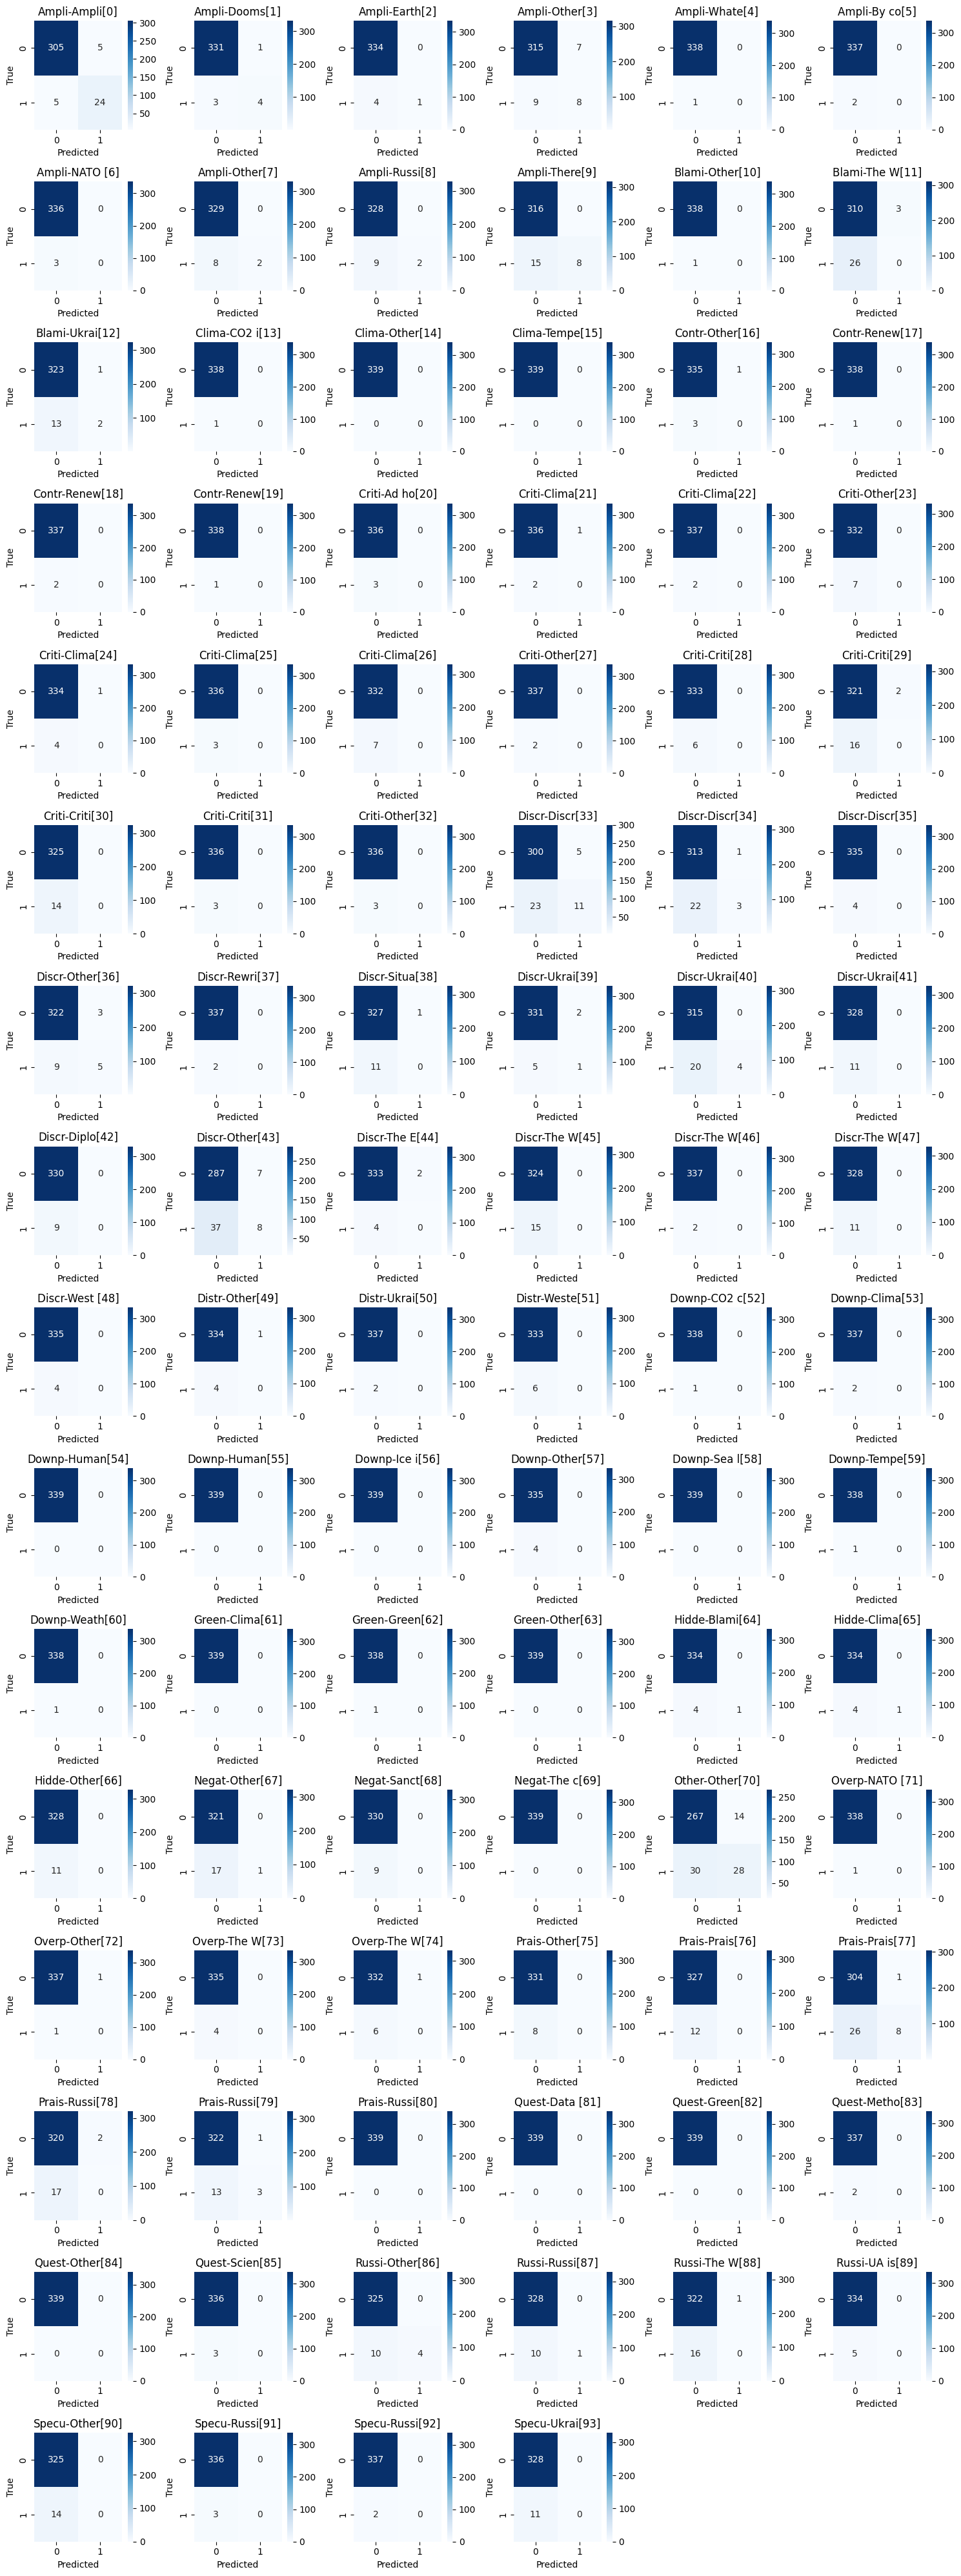

In [15]:
print("Results using TF-IDF Vectorizer:")

print("Complete Data:")
show_class_occurrences(counts_df_tfidf_compl)
show_confusion_matrix(df, conf_matr_tfidf_compl)


#print("Ukraine War Data:")
#show_class_occurrences(counts_df_tfidf_ua)
#show_confusion_matrix(conf_matr_tfidf_ua)

# print("Climate Change Data:")
# show_class_occurrences(counts_df_cc)
# show_confusion_matrix(conf_matr_cc)


# print("Results using Bag-Of-Words Vectorizer:")

# print("Complete Data:")
# show_class_occurrences(counts_df_bow_compl)
# show_confusion_matrix(conf_matr_bow_compl)


# print("Results using Multilingual Embeddings:")

# print("Complete Data:")
# show_class_occurrences(counts_df_mult_compl)
# show_confusion_matrix(conf_matr_mult_compl)

### Result analysis

#### General Considerations
- To evaluate performance, we look at the **recall, precision and f1-score**

- We argue that a **high recall is more relevant** for this task. Given the example of assigning articles on X (formerly twitter)  to certain narratives to flag to it like "A problematic narrative x might be contained in this article", we are more interested in actually finding all relevant narratives.
- Therefore, if we optimise our results, we will do it with respect to recall.

- From the occurences tables, we identify class imbalance as a big problem, and many classes only have very few instances. 
- Especially {narrative:"other, subnarrative:"Other"} is highly represented in the data
- Many other narratives are strongly underrepresented, some only having a single instance.

- Further, we notice that the results vary significantly with the seed. This is a further indicator, that the general amount of data might not be sufficient.


#### Confusion Matrix and Occurances Table
- For each label, we show the confusion matrix and give an overview of its occurences in the data and the predictions.
- The model seems to capture some classes quite well. E.g. for narrative with index 0, the model is able to identify 24 out 29 times. 
- Most classes, however, are almost never predicted by the model. While this leads to few false positives, we also rarely correctly identify a positive case leading to many false negatives. The narrative with index 78 occurs 17 times in the test set, but the model only predicts it twice (both of which are incorrect).
- Most clearly, we can identify a trend of the model towards predicting the class 'Other-Other', while ignoring other narratives. This is also the most represented class overall. While some narratives don't appeaer at all or only few times in the test set, 'Other-Other' has over 70 instances.
- In the early stages of the project, we were only working with english data. This made the class imbalance and the resulting performance issues even more visible. 

#### Splitting data into ukraine war and climate change
- All methods yield overall much better results across metrics on the Ukraine-war dataset compared to the Climate-Change dataset, with the results of the full dataset somewhere in between. 
- Therefore, the hypothesis that splitting the dataset to reduce task complexity improves performance can not be definitely confirmed.


#### Representation Method
- Regarding the vectorization methods used with SVM, we note that TF-IDF yields the best results across almost all datasets and metrics. 
- Compared to bag-of-words this makes sense, since besides word-frequency, TF-IDF additionally accounts for document length.
- When adding more languages to increase the data set size, we added multilingual embeddings as another representation method, to account for the differences in languages. Against our expectations, this did not increase the performance of the SVM.

#### Solution Approaches
Underrepresented classes with only very few instances make the task very challenging. Possible strategies would include

- Using SMOTE to create synthetic training instances for underrepresented classes
- Using Oversampling


### Analysis of the performance differences between narratives

We note that the model achieves a better recall on some narratives than on other. We want to find out whether the origins of that lie in the input itself, specifically whether for some classes, the vectorization method (tf-idf) creates vectors that are more distinguishable from the rest than for other classes.

To this end, for each class (that has at least 5 positives overall) we calculate the average of the vectors belonging to it. Further, we calculate the average over the vectors that don't belong to it. With this, we then calculate the euclidean distance between each class and the rest and plot the results in the first figure following below.

Another potential reason for the performance differences lies in the support of each class. Therefore we plot it as an additional line.

2025-01-25 10:42:25,947 - modules.modules_svm.preprocessing_svm - INFO - Created mapping for 94 unique narratives


c:\Users\Niklas\Documents\Master\Semester1\3 NLP and Information Extraction\nlp_Backpropagandists_2024\code\modules\modules_svm\analysis_util_svm.py:254: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(x_tick_labels, rotation=45, ha='right')


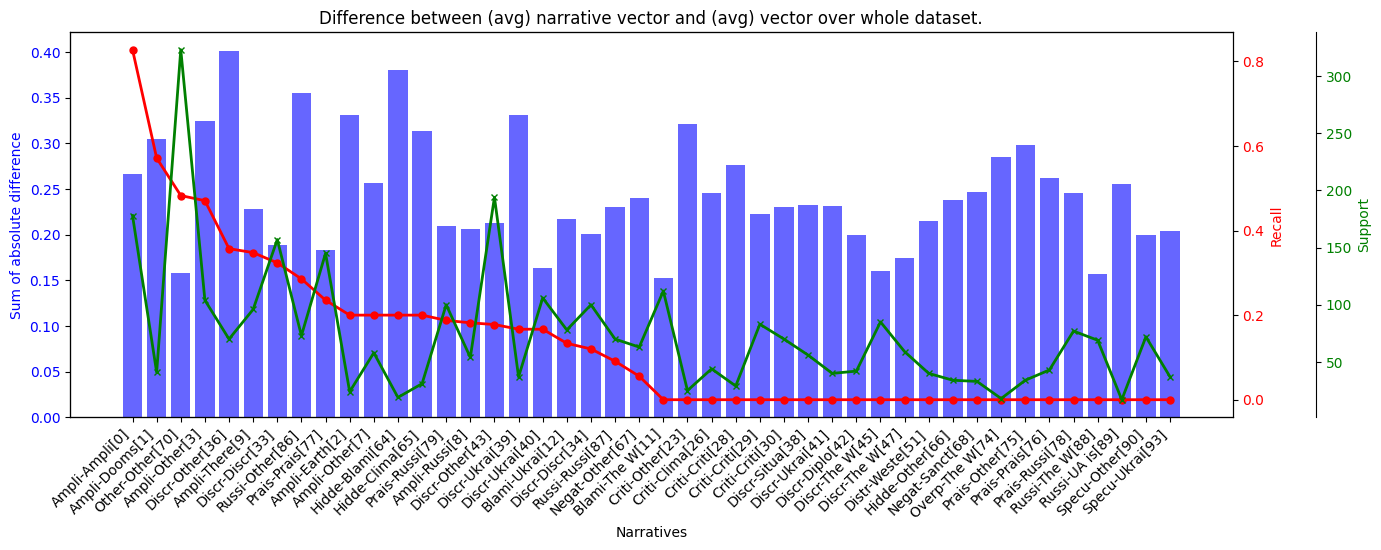

In [16]:
all_narratives = df['narrative_subnarrative_pairs'].apply(
            lambda x: eval(x) if isinstance(x, str) else x
        ).tolist()
label_mapping = create_label_mapping(all_narratives)
        
texts, labels, label_mapping, filenames = prepare_data(df, label_mapping)
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(texts)

good_narratives, bad_narratives, sorted_narratives = sort_narratives_recall(conf_matr_tfidf_compl)
plot_difference_barchart(X, labels, sorted_narratives, label_mapping)


The above figure shows how „different“ each class is to the average of the dataset, computed as explained above, and the support of each class. Further it shows the recall as indicator of how well the model was able to identify the class. 

We would expect, that classes, whose vector representations are very different to the mean of the dataset, lead to a high recall, as they are better „distinguishable“/„separable“. Further we expect, that classes with a high support yield better recall, as the model has more positive instances to learn from.

In the plot this trend is not so clearly visible. Many of the classes with recall 0.0 have a similar or larger difference value than classes where the model achieved a high recall. Similar, there are several classes with high recall, that have only a small support. When looking at the difference values and support together, the trend gets more plausible: For most classes with high recall, at least one of them is high as well. From this, one could argue that for good results, the model needs the classes to be either easily separable from the rest ("large difference value") or have many instances, which the model can learn from ("high recall"). 

However, this conclusion should be taken with caution, as the trend is not clearly evident, especially for the difference values. One potential reason is the chosen method of calculating the separability of a class (euclidean distance), which might not be representable enough. All in all, the support of a class still seems to be the most important factor.

## Qualitative result analysis

Quantitative analyses using confusion matrices and metrics rarely show the whole picture of a prediction task. Therefore it is necessary to look at individual outputs in detail to understand why a model behaves in a certain way. Among other things, this is important to make the algorithm's decisions more explainable to key stakeholders and build trust towards the predictions.

In [17]:
# Remove training part of the dataframe # May be redundant now, check
df_w_preds_tfidf_compl = df_w_preds_tfidf_compl.dropna(subset=['predicted_labels'])
df_w_preds_tfidf_compl.reset_index(drop=True, inplace=True)

In [18]:
df_w_preds_tfidf_compl.drop(columns=["target_indices", "tokens"], inplace=True)

In [19]:
df_w_preds_tfidf_compl.head()

,filename,language,content,topic,narrative_subnarrative_pairs,tokens_normalized,predicted_labels,true_labels
0,EN_UA_102703.txt,EN,Millions left with no aid as West Africa suffe...,UA,"[{'narrative': 'Other', 'subnarrative': 'Other'}]","['million', 'leave', 'aid', 'west', 'africa', ...",[],"[[{'narrative': 'Other', 'subnarrative': 'Othe..."
1,EN_UA_102034.txt,EN,Most Taiwanese do not view US as ‘trustworthy’...,UA,"[{'narrative': 'Discrediting the West, Diploma...","['taiwanese', 'view', 'trustworthy', 'majority...","[[{'narrative': 'Other', 'subnarrative': 'Othe...","[[{'narrative': 'Discrediting the West, Diplom..."
2,EN_CC_100044.txt,EN,The bottom-up Brussels green revolution \r\n\r...,CC,"[{'narrative': 'Other', 'subnarrative': 'Other'}]","['bottomup', 'brussels', 'green', 'revolution'...","[[{'narrative': 'Other', 'subnarrative': 'Othe...","[[{'narrative': 'Other', 'subnarrative': 'Othe..."
3,EN_CC_200104.txt,EN,Media weather anomalies and the propagandist B...,CC,"[{'narrative': 'Downplaying climate change', '...","['media', 'weather', 'anomaly', 'propagandist'...",[],"[[{'narrative': 'Downplaying climate change', ..."
4,EN_UA_002531.txt,EN,Kyiv's Mayor Says He's 'Ready to Fight' as Rus...,UA,"[{'narrative': 'Other', 'subnarrative': 'Other'}]","['kyiv', 'mayor', 'say', 'ready', 'fight', 'ru...","[[{'narrative': 'Other', 'subnarrative': 'Othe...","[[{'narrative': 'Other', 'subnarrative': 'Othe..."


In [20]:
print(df_w_preds_tfidf_compl.loc[1, 'true_labels'])

[[{'narrative': 'Discrediting the West, Diplomacy', 'subnarrative': 'Other'}, 43]]


#### Class 64: {'narrative': 'Hidden plots by secret schemes of powerful groups', 'subnarrative': 'Blaming global elites'}

With roughly 100 classes and imbalanced classes, it is difficult to pick what classes might be interesting for the qualitative analysis. While not all classes can be explored, we also want to avoid cherry picking but still analyse classes that might be interesting. If a class is never predicted by the model, it might be interesting why this is the case, but the default assumption might always be that not enough data was present (this aligns with the fact that low support classes are generally predicted worse/not at all).


**Language considerations**

By using only languages that we can understand (russian and german), the results were very poor due to too little support for almost all classes with a still very large prediction output space. With this, a sensible qualitative analysis would amount to "almost all classes are not predicted at all since the data is not sufficient". To avoid this issue, we opted for incorporating all available languages which lead to far more positive predictions by the model. At the latest for the qualitative analysis, this becomes an issue since not all articles can be analysed. We still think this approach is more sensible and we will analyse classes where multiple interesting english datapoints were predicted.

Especially interesting to us are classes where there are true positives and false negatives, meaning the model predicted the class correctly at least once, but also mistakenly did not predict it even though a class applied.

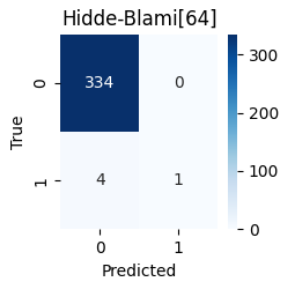

In [21]:
# Get class indices with english true positives and false negatives
classes_with_tp_fn_language_check = find_classes_with_tp_and_fn_language_check(df_w_preds_tfidf_compl)

# Display the resulting class indices
print("Class indices with at least one true positive and one false negative (language = EN):", classes_with_tp_fn_language_check)

Class indices with at least one true positive and one false negative (language = EN): [70, 64, 65, 9]


In [22]:
# Define the target label for analysis
target_label = 64

# Extract true positives and false negatives for target label
false_negatives, true_positives = extract_confusion_data(df_w_preds_tfidf_compl, target_label)

false_negatives_df = pd.DataFrame(false_negatives)
true_positives_df = pd.DataFrame(true_positives)

true_positives_df.head()


,filename,language,content,topic,narrative_subnarrative_pairs,tokens_normalized,predicted_labels,true_labels
79,EN_CC_200093.txt,EN,NO MORE AIR TRAVEL: Globalists want to close (...,CC,[{'narrative': 'Criticism of climate movement'...,"['air', 'travel', 'globalist', 'want', 'close'...",[[{'narrative': 'Controversy about green techn...,[[{'narrative': 'Criticism of climate movement...


In [23]:
print(true_positives_df.loc[79, "predicted_labels"])

[[{'narrative': 'Controversy about green technologies', 'subnarrative': 'Other'}, 16], [{'narrative': 'Criticism of climate movement', 'subnarrative': 'Climate movement is alarmist'}, 21], [{'narrative': 'Hidden plots by secret schemes of powerful groups', 'subnarrative': 'Blaming global elites'}, 64], [{'narrative': 'Hidden plots by secret schemes of powerful groups', 'subnarrative': 'Climate agenda has hidden motives'}, 65]]


In [24]:
print(true_positives_df.loc[79, "true_labels"])

[[{'narrative': 'Criticism of climate movement', 'subnarrative': 'Other'}, 23], [{'narrative': 'Hidden plots by secret schemes of powerful groups', 'subnarrative': 'Blaming global elites'}, 64], [{'narrative': 'Hidden plots by secret schemes of powerful groups', 'subnarrative': 'Climate agenda has hidden motives'}, 65]]


In [25]:
print(true_positives_df.loc[79, "content"])

NO MORE AIR TRAVEL: Globalists want to close (nearly) all airports by 2050 to achieve “climate change” targets 

 A report from these two schools says that with the exception of Heathrow, Glasgow, and Belfast, all other smaller and local airports will need to disappear by 2029 in order for the war on "global warming" and "climate change" to eventually be won.

Air travelers who require regional transfers to and from the three larger airports after that time will need to take rail or a car instead, as these are considered by the globalists to be much better forms of transport for the climate.

The only way for even Heathrow, Glasgow, and Belfast to remain open between 2029 and 2049 is if all other airports close down by 2029, and if all air transfers within the UK be migrated to ground transfers. If that is achieved, then the Big Three can stay open until 2049.

After that, the report states, all airports, including the Big Three, will need to be closed down permanently, leaving residen

In [26]:
false_negatives_df.head()

,filename,language,content,topic,narrative_subnarrative_pairs,tokens_normalized,predicted_labels,true_labels
7,EN_CC_100014.txt,EN,If they are willing to poison the chickens to ...,CC,[{'narrative': 'Hidden plots by secret schemes...,"['willing', 'poison', 'chicken', 'stop', 'lay'...",[],[[{'narrative': 'Hidden plots by secret scheme...
38,EN_CC_100002.txt,EN,Oxford Residents Mount Resistance Against the ...,CC,[{'narrative': 'Criticism of institutions and ...,"['oxford', 'resident', 'mount', 'resistance', ...",[],[[{'narrative': 'Criticism of institutions and...
64,EN_CC_100035.txt,EN,"Cows Join Bald Eagles, Whales On The Left’s Cl...",CC,[{'narrative': 'Criticism of institutions and ...,"['cow', 'join', 'bald', 'eagle', 'whale', 'lea...",[],[[{'narrative': 'Controversy about green techn...
127,BG_894.txt,BG,"Зелената сделка: Бедност, мизерия и по-малко х...",CC,[{'narrative': 'Criticism of institutions and ...,"['зелен', 'сделка', 'бедност', 'мизерия', 'пом...",[],[[{'narrative': 'Criticism of climate movement...


In [27]:
print(false_negatives_df.loc[7, "content"])

If they are willing to poison the chickens to stop them from laying eggs, they are likely poisoning the HUMAN food supply to stop us from having children 

 A few globalist-owned and controlled animal feed companies are supplying farmers with tainted chicken feed that allegedly prevent hens from producing eggs, adding to the chaotic food shortages and supply chain breakdowns. Is this another attempt to cripple the entire food supply, including meat and eggs, so everyone will run to the grocery stores and buy genetically-mutated, lab-concocted Franken-meat that Bill Gates funds? It would appear so.

Not only are hens unable to lay eggs for months after consuming globalist-manufactured tainted feed, but could it be possible those chickens and eggs are also toxic for humans to consume, possibly causing infertility issues for them also? Local egg suppliers and farmers are blowing the whistle on what could be the tip of the iceberg when it comes to corporations purposely trying to cripple t

In [28]:
print(false_negatives_df.loc[38, "content"])

Oxford Residents Mount Resistance Against the Sectioning of Their Streets 

 OXFORD RESIDENTS MOUNT RESISTANCE AGAINST THE SECTIONING OF THEIR STREETS

THE GREAT CLIMATE CON

Oxford residents are taking matters into their own hands and destroying the street zone sectioning barriers.

Oxford is going to be the centre of the resistance to the climate change madness in the UK.

.

Just recently there was a day of action by activists to kick start the year of fighting back. We predicted the UK was just getting started with their resistance, and here we have it. Taking matters into their own hands, Oxford residents are destroying street zoning barriers.

Now that’s quite beautiful to see.

Further action

There are further planned dates for activists to take to the streets in various forms of protest.

Piers Corbyn and friends are taking to the streets on Friday the 13th of January., Starting at Southwark tube in London.

Then an event which has potential to draw a large crowd with reports 

In [29]:
print(false_negatives_df.loc[64, "content"])

Cows Join Bald Eagles, Whales On The Left’s Climate Kill List 

 What happened: European bureaucrats in dreary Ireland are plotting the murder of roughly 200,000 cows in order to combat so-called climate change.

• Mass execution is one of the options being considered by the Irish government as it scrambles to satisfy the European Union’s draconian emissions targets by 2030.

Context: European libs aren’t the only ones trying to erase cows from existence.

In 2019, Rep. Alexandria Ocasio-Cortez (D., N.Y.) promoted the controversial Green New Deal legislation using a fact sheet promising to “fully get rid of farting cows and airplanes.”

Why it matters: Liberal activists have long sought to alleviate their personality disorders, sometimes referred to as “climate anxiety,” by killing innocent animals.

• Former president Barack Obama deployed solar farms, wind farms, and other “clean energy” murder machines to execute thousands of bald eagles on his watch.

• More recently, Democrats in 

TF-IDF represents words based on their occurance in the whole dataset and the document, with words with high occurance in the document have higher weight and words that occur frequently across the datasets have a lower weight.

For this class, we are now interested in the question why the first article was correctly classified as the class while the others were not predicted even though the class applied.

For the correctly identified article "NO MORE AIR TRAVEL", there are multiple potential high impact words that might tie it to the class, such as occurances of "globalist", "extremist", "sinister", "agenda" or "genocide". This article is arguably also for a human the most clearly associated one with the class.

For the articles not classified as the class:
The article about chicken food poisoning has some potential high impact words including "globalist", but the general corpus of words lends more towards a more neutral tone since the article actually talks more about food-relted vocabulary than using words about schemes by powerful groups. 

In the remaining two articles not identified as class 64, it appears that the word "globalist" does not occur, indicating it might contribute to identifying the class.

For "Oxford Residents Mount Resistance Against the Sectioning of Their Streets", only a short section of text is actually about the topic while the rest is about the website itself. Even for a human, it is arguable whether this article falls under the subnarrative "blaming global elites", as the article does not mention any institutions, groups or elites.

With "Cows Join Bald Eagles, Whales On The Left’s Climate Kill List", the language is also less extreme, e.g. not mentioning conspirational terms like "globalists" but directly addressing "liberals" or the "left".

**General observations:**

This example also shows that there is quite a bit of subjectivity to classifying narratives.
- Firstly, in the article about "Oxford Residents", no powerful groups or global elites are mentioned explicitly. As a human the narrative can perhaps be implied, but it is hard to see how the subnarrative "Blaming global elites" is applicable here. 
- Secondly, The true positive for class 64 was also classified by the model as {'narrative': 'Criticism of climate movement', 'subnarrative': 'Climate movement is alarmist'} while another true label was {'narrative': 'Criticism of climate movement', 'subnarrative': 'Other'}. The subnarratives under a narrative are often quite nuanced, making the classification task harder, but also the labeling decision.


**Most important words**
Lastly, we want to have a look at which would have been the most important terms for this class. For this, we compute the difference similar to our analysis in the previous chapter: We build the average over the instances belonging to this class and compare it to the rest of the data. This time, zoom in one more level, showing how the frequency of each word differs. This should give us an idea of which words are important for this class. To prevent overplotting, we limit ourselves to the 100 words with the biggest difference values.

c:\Users\Niklas\Documents\Master\Semester1\3 NLP and Information Extraction\nlp_Backpropagandists_2024\.venv\Lib\site-packages\seaborn\utils.py:61: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.draw()
c:\Users\Niklas\Documents\Master\Semester1\3 NLP and Information Extraction\nlp_Backpropagandists_2024\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)


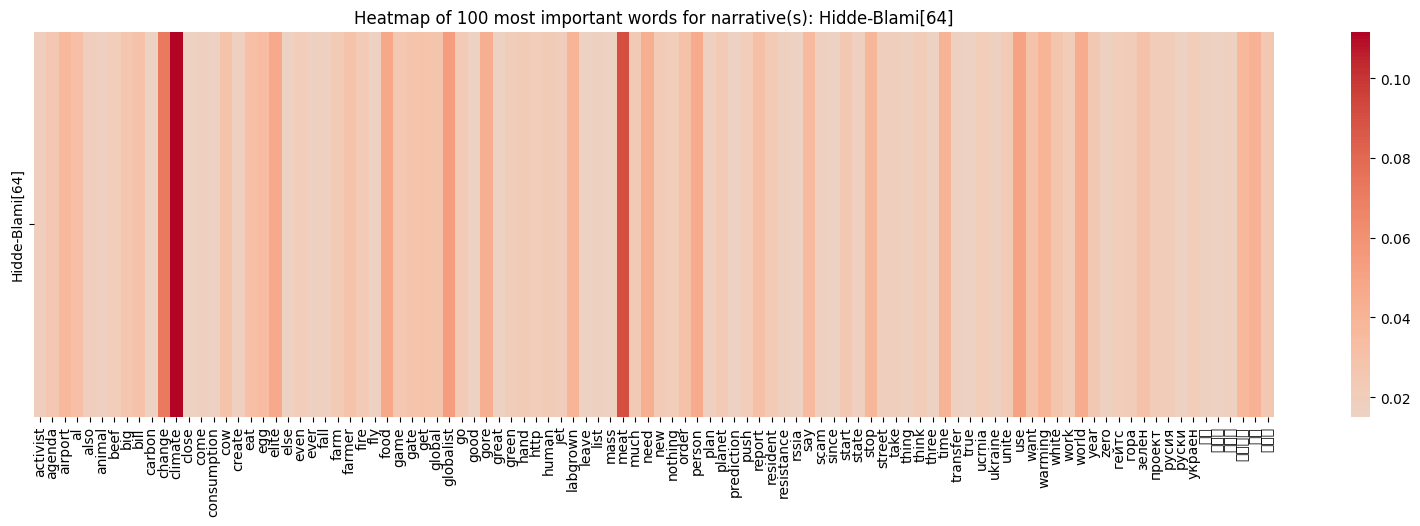

In [30]:
warnings.filterwarnings("ignore", ".*Glyph.*") # ignore warnings related to indian fonts
plot_differences_heatmap(X, labels, label_mapping, vectorizer, narratives=[64])

From the heatmap we can extract, that several words show large differences in frequency compared to non-class instances. Considering, that our narrative is called  "Hidden plots by secret schemes of powerful groups- Blaming global elites", some of them are expected: "climate", "elite", "globalist", "world". However there are also many, that seem totally unrelated, such as "eat", "egg", "food", "meat" and "time". 

This shows that while tf-idf emphasizes some important features, it also weights some unrelated features. This could be misleading for the model and points to a possible reason for the poor performance in this class.

#### What actually falls into the other-other class?

Logically, the other-other class is a collection of two things:
- Articles that are a narrative, but not a narrative defined in the dataset's taxonomy
- Articles that might simply not be propaganda, as there is no direct propaganda/no-propaganda distinction built into the task

It is therefore an interesting class to look at to get a feeling for what actually is classified as propaganda by the dataset creators.

In [31]:
# Define the target label for analysis
target_label = 70

# Extract true positives and false negatives for target label
false_negatives, true_positives = extract_confusion_data(df_w_preds_tfidf_compl, target_label)

false_negatives_df = pd.DataFrame(false_negatives)
true_positives_df = pd.DataFrame(true_positives)

In [32]:
true_positives_df.head()

,filename,language,content,topic,narrative_subnarrative_pairs,tokens_normalized,predicted_labels,true_labels
2,EN_CC_100044.txt,EN,The bottom-up Brussels green revolution \r\n\r...,CC,"[{'narrative': 'Other', 'subnarrative': 'Other'}]","['bottomup', 'brussels', 'green', 'revolution'...","[[{'narrative': 'Other', 'subnarrative': 'Othe...","[[{'narrative': 'Other', 'subnarrative': 'Othe..."
4,EN_UA_002531.txt,EN,Kyiv's Mayor Says He's 'Ready to Fight' as Rus...,UA,"[{'narrative': 'Other', 'subnarrative': 'Other'}]","['kyiv', 'mayor', 'say', 'ready', 'fight', 'ru...","[[{'narrative': 'Other', 'subnarrative': 'Othe...","[[{'narrative': 'Other', 'subnarrative': 'Othe..."
15,EN_UA_002991.txt,EN,"Russian On-air Protester Fined, Faces Possible...",UA,"[{'narrative': 'Other', 'subnarrative': 'Other'}]","['russian', 'onair', 'protester', 'fined', 'fa...","[[{'narrative': 'Other', 'subnarrative': 'Othe...","[[{'narrative': 'Other', 'subnarrative': 'Othe..."
21,EN_UA_300058.txt,EN,Russia Turns Missiles on Ukraine's Farm Storag...,UA,"[{'narrative': 'Other', 'subnarrative': 'Other'}]","['russia', 'turn', 'missile', 'ukraine', 'farm...","[[{'narrative': 'Other', 'subnarrative': 'Othe...","[[{'narrative': 'Other', 'subnarrative': 'Othe..."
23,EN_UA_104604.txt,EN,Reporter who helped reveal assassination plot ...,UA,"[{'narrative': 'Other', 'subnarrative': 'Other'}]","['reporter', 'help', 'reveal', 'assassination'...","[[{'narrative': 'Other', 'subnarrative': 'Othe...","[[{'narrative': 'Other', 'subnarrative': 'Othe..."


In [33]:
print(true_positives_df.loc[21, "content"])

Russia Turns Missiles on Ukraine's Farm Storage 

 Russian cruise missiles, flying low and hugging the terrain to dodge Ukrainian air defenses, destroyed farm storage buildings in the Odesa region early Friday, Ukrainian officials said, as the Kremlin’s forces expanded their targets following three days of bombardment of the region’s Black Sea port infrastructure.

Two missiles struck the storage facility, starting a fire, and while workers fought to put it out another missile hit, destroying farm and firefighting equipment, the southern Odesa region’s Gov. Oleh Kiper said.

The attack injured two people and destroyed 100 metric tons of peas and 20 metric tons of barley, according to Kiper.

The attack was small-scale in comparison with barrages in recent days that put Odesa in Russia’s crosshairs after Moscow tore up a wartime deal that allowed Ukraine to send grain through the key Black Sea port.

Russia targeted Ukrainian critical grain export infrastructure after vowing to retaliat

EN_UA_300058.txt above with true label other-other, is an example of an article from the western perspective. There are few polarising/extreme words in comparison with the articles above and appears to be more fact-based. It appears reasonable, from a western perspective, that it is not classified as any of the "actual" narratives and it is likely intended that this article has no narrative.

In [34]:
print(true_positives_df.loc[77, "content"])

Feature: Los Angeles marks Indigenous Peoples' Day with celebrations at Getty Center 

Getty Center, one of the top attractions in the U.S. West Coast city of Los Angeles, celebrated the annual Indigenous Peoples' Day over the weekend with an expansive family event aimed at highlighting both traditional and contemporary Indigenous perspectives.

The gathering on Saturday was part of Getty's continuous efforts to celebrate Southern California's vibrant Native American cultures. Sitting atop a hill in the Santa Monica Mountains, the Getty Center, a campus of the Getty Museum and other programs of the Getty Trust, took around 1.3 billion U.S. dollars to build and opened in December 1997. It is well known for its architecture, gardens, and bird's-eye views of Los Angeles.

Building on last year's success, where attendees learned about native plant dyes and relished musical performances, this year's event in the museum had a broader scope.

Generous support for this year's celebration came 

Same as above, there appears to be no extreme language or questionable opinions, meaning this article is intended by the dataset creators as having no narrative.

In [35]:
false_negatives_df.head()

,filename,language,content,topic,narrative_subnarrative_pairs,tokens_normalized,predicted_labels,true_labels
0,EN_UA_102703.txt,EN,Millions left with no aid as West Africa suffe...,UA,"[{'narrative': 'Other', 'subnarrative': 'Other'}]","['million', 'leave', 'aid', 'west', 'africa', ...",[],"[[{'narrative': 'Other', 'subnarrative': 'Othe..."
6,EN_UA_028103.txt,EN,Russian Plot To Assassinate CEO Of German Arms...,UA,"[{'narrative': 'Other', 'subnarrative': 'Other'}]","['russian', 'plot', 'assassinate', 'ceo', 'ger...",[],"[[{'narrative': 'Other', 'subnarrative': 'Othe..."
8,EN_CC_100091.txt,EN,FACT CHECK: Did Greta Thunberg Say Saving The ...,CC,"[{'narrative': 'Other', 'subnarrative': 'Other'}]","['fact', 'check', 'greta', 'thunb', 'say', 'sa...",[],"[[{'narrative': 'Other', 'subnarrative': 'Othe..."
22,EN_UA_300023.txt,EN,Russia to Stage ‘Unwelcome’ Live-Fire Naval Dr...,UA,"[{'narrative': 'Other', 'subnarrative': 'Other'}]","['russia', 'stage', 'unwelcome', 'livefire', '...",[],"[[{'narrative': 'Other', 'subnarrative': 'Othe..."
28,EN_UA_027816.txt,EN,Russia bans over 80 EU media outlets including...,UA,"[{'narrative': 'Other', 'subnarrative': 'Other'}]","['russia', 'ban', 'eu', 'media', 'outlet', 'in...",[],"[[{'narrative': 'Other', 'subnarrative': 'Othe..."


In [36]:
false_negatives_df[(false_negatives_df['predicted_labels'].apply(lambda x: len(x) == 0)) & (false_negatives_df['language'] == 'EN')]

,filename,language,content,topic,narrative_subnarrative_pairs,tokens_normalized,predicted_labels,true_labels
0,EN_UA_102703.txt,EN,Millions left with no aid as West Africa suffe...,UA,"[{'narrative': 'Other', 'subnarrative': 'Other'}]","['million', 'leave', 'aid', 'west', 'africa', ...",[],"[[{'narrative': 'Other', 'subnarrative': 'Othe..."
6,EN_UA_028103.txt,EN,Russian Plot To Assassinate CEO Of German Arms...,UA,"[{'narrative': 'Other', 'subnarrative': 'Other'}]","['russian', 'plot', 'assassinate', 'ceo', 'ger...",[],"[[{'narrative': 'Other', 'subnarrative': 'Othe..."
8,EN_CC_100091.txt,EN,FACT CHECK: Did Greta Thunberg Say Saving The ...,CC,"[{'narrative': 'Other', 'subnarrative': 'Other'}]","['fact', 'check', 'greta', 'thunb', 'say', 'sa...",[],"[[{'narrative': 'Other', 'subnarrative': 'Othe..."
22,EN_UA_300023.txt,EN,Russia to Stage ‘Unwelcome’ Live-Fire Naval Dr...,UA,"[{'narrative': 'Other', 'subnarrative': 'Other'}]","['russia', 'stage', 'unwelcome', 'livefire', '...",[],"[[{'narrative': 'Other', 'subnarrative': 'Othe..."
28,EN_UA_027816.txt,EN,Russia bans over 80 EU media outlets including...,UA,"[{'narrative': 'Other', 'subnarrative': 'Other'}]","['russia', 'ban', 'eu', 'media', 'outlet', 'in...",[],"[[{'narrative': 'Other', 'subnarrative': 'Othe..."
31,EN_CC_100030.txt,EN,Chart of the Week: Clean Energy Themes \r\n\r\...,CC,"[{'narrative': 'Other', 'subnarrative': 'Other'}]","['chart', 'week', 'clean', 'energy', 'theme', ...",[],"[[{'narrative': 'Other', 'subnarrative': 'Othe..."
37,EN_CC_200349.txt,EN,Great Barrier Reef Doomsday Claims Should Be A...,CC,"[{'narrative': 'Other', 'subnarrative': 'Other'}]","['great', 'barrier', 'reef', 'doomsday', 'clai...",[],"[[{'narrative': 'Other', 'subnarrative': 'Othe..."
47,EN_UA_300029.txt,EN,Ukraine war may bring windfall to Indonesia's ...,UA,"[{'narrative': 'Other', 'subnarrative': 'Other'}]","['ukraine', 'war', 'may', 'bring', 'windfall',...",[],"[[{'narrative': 'Other', 'subnarrative': 'Othe..."
48,EN_UA_100106.txt,EN,Election in Nigeria triggers deluge of 'misinf...,UA,"[{'narrative': 'Other', 'subnarrative': 'Other'}]","['election', 'nigeria', 'trigger', 'deluge', '...",[],"[[{'narrative': 'Other', 'subnarrative': 'Othe..."
49,EN_UA_102963.txt,EN,Ukraine's President Zelenskyy to address Mexic...,UA,"[{'narrative': 'Other', 'subnarrative': 'Other'}]","['ukraine', 'president', 'zelenskyy', 'address...",[],"[[{'narrative': 'Other', 'subnarrative': 'Othe..."
